In [1]:
import tobler
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_rows = 1000 # this will set limit of rows to 500

# LandScan population statistics for day and nighttime, aggregated to hexes
hexes     = gpd.read_file('../data/shapefiles/nyc/population_hexbinned.geojson')

# table of in-/out-flow taxi rides per taxi zone, hour/day/month
rides     = pd.read_csv('../data/tables/fhv19.csv')

# taxi zone shapefile
tz        = gpd.read_file('../data/shapefiles/nyc/taxi_zones.geojson')\
               .to_crs(hexes.crs)
keep_cols = ['location_id', 'zone', 'geometry']
tz        = tz[keep_cols] # filter columns

# renaming tz column and resetting type to int
tz.rename(columns={'location_id': 'taxizoneID'},
          inplace=True)
tz['taxizoneID'] = tz['taxizoneID'].astype(int)

# fixing data duplication error in the TZ dataset
tz.iloc[56,  tz.columns.get_loc('taxizoneID')] = 57
tz.iloc[103, tz.columns.get_loc('taxizoneID')] = 104
tz.iloc[104, tz.columns.get_loc('taxizoneID')] = 105

In [2]:
rides['month']  = rides.apply(lambda row: row['time'].split('/')[0], axis=1)
rides['day']    = rides.apply(lambda row: row['time'].split('/')[1], axis=1)
rides['night?'] = rides.apply(lambda row: 0 if row['timegroupstr'] == 'daytime' else 1, axis=1)

rides['month']  = rides['month'].astype(int)
rides['day']    = rides['day'].astype(int)
rides['night?'] = rides['night?'].astype(int)

In [3]:
# pivot table to sum day/night rides by taxi zone, day, and month
table = pd.pivot_table(rides,
                       values=['inflow_counts', 'outflow_counts'],
                       index=['taxizoneID', 'month', 'day', 'weekday', 'night?'],
                       aggfunc=np.sum).reset_index()

In [4]:
# summary stats and quick head view
print(f"{table.shape[0]} total records in the rides dataset.")
print(f"{len(table.taxizoneID.unique())} total taxi zones represented over "
     + f"{len(table.month.unique())} months in 2019.")
print()
table.head()

63383 total records in the rides dataset.
263 total taxi zones represented over 5 months in 2019.



,taxizoneID,month,day,weekday,night?,inflow_counts,outflow_counts
0,1,1,1,Tuesday,0,4038,153
1,1,1,1,Tuesday,1,234,85
2,1,1,2,Wednesday,0,3821,139
3,1,1,2,Wednesday,1,284,72
4,1,1,3,Thursday,0,2702,76


In [5]:
tz_merged = tz.merge(table, on='taxizoneID', how='right')

tz_merged.head(3)

,taxizoneID,zone,geometry,month,day,weekday,night?,inflow_counts,outflow_counts
0,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,1,Tuesday,0,4038,153
1,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,1,Tuesday,1,234,85
2,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,2,Wednesday,0,3821,139


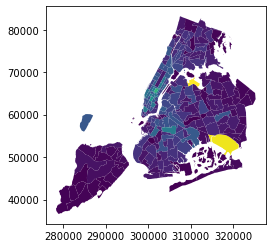

In [6]:
tz_merged[(tz_merged['month'] == 3) &\
          (tz_merged['day'] == 1) &\
          (tz_merged['night?'] == 0)].plot(column='inflow_counts');

In [28]:
## use this first snippet for faster testing
# tz_selected = tz_merged[(tz_merged['month'] == 3) &\
#                         (tz_merged['day'] == 1) &\
#                         (tz_merged['night?'] == 0)]

# filter out airports from study area
tz_no_airports = tz_merged[~tz_merged['zone'].str.contains('Airport')]

In [32]:
estimates = tobler.area_weighted\
                  .area_interpolate(tz_no_airports,
                                    hexes,
                                    extensive_variables=['inflow_counts',
                                                         'outflow_counts'],
                                   )

estimates.head()

,inflow_counts,outflow_counts,geometry
0,1601.492699,1143.416184,"POLYGON ((317847.498 76722.030, 317308.379 766..."
1,4829.116250,4232.074674,"POLYGON ((317141.941 76108.944, 317308.379 766..."
2,21270.984142,21053.825526,"POLYGON ((314406.473 76893.202, 314572.847 773..."
3,2272.599929,1497.308475,"POLYGON ((315691.048 76253.129, 315524.655 757..."
4,10049.422002,9521.489593,"POLYGON ((315111.986 77506.347, 315278.384 780..."


In [53]:
tz_no_airports.head(3)

,taxizoneID,zone,geometry,month,day,weekday,night?,inflow_counts,outflow_counts
241,2,Jamaica Bay,"MULTIPOLYGON (((314941.095 52464.112, 314993.0...",1,1,Tuesday,0,0,0
242,2,Jamaica Bay,"MULTIPOLYGON (((314941.095 52464.112, 314993.0...",1,1,Tuesday,1,0,0
243,2,Jamaica Bay,"MULTIPOLYGON (((314941.095 52464.112, 314993.0...",1,2,Wednesday,0,2,1


In [51]:
print(tz_no_airports.shape)
print(hexes.shape)

(62660, 9)
(1128, 8)


KeyboardInterrupt: 

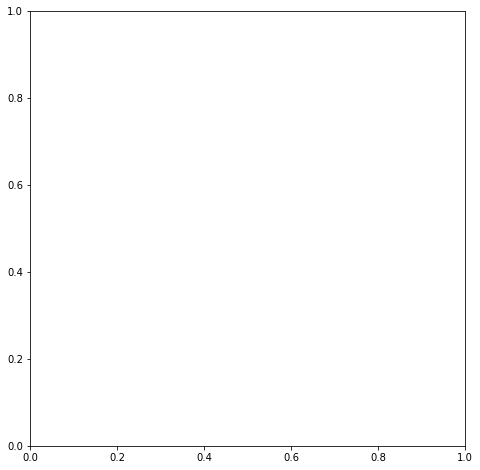

In [45]:
# inflow per taxizone on march 1st (friday) during the day
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tz_no_airports.plot(column='inflow_counts',
                         ax=ax,
                         legend=True,
                         legend_kwds={'loc': 'upper left'},
                         alpha=0.7,
                         scheme='FisherJenks',
                         k=5)
plt.show();

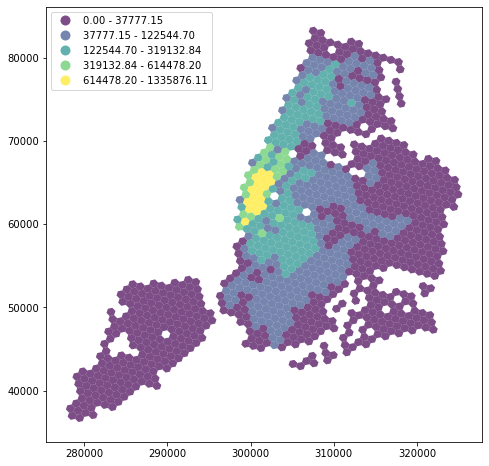

In [46]:
# inflow per hexbin on march 1st (friday) during the day
hexes['inflow_counts_daysample'] = estimates['inflow_counts']
hexes.head()

f, ax = plt.subplots(1, figsize=(8, 8))
ax = hexes.plot(column='inflow_counts_daysample',
                ax=ax,
                legend=True,
                legend_kwds={'loc': 'upper left'},
                alpha=0.7,
                scheme='FisherJenks',
                k=5)
plt.show();

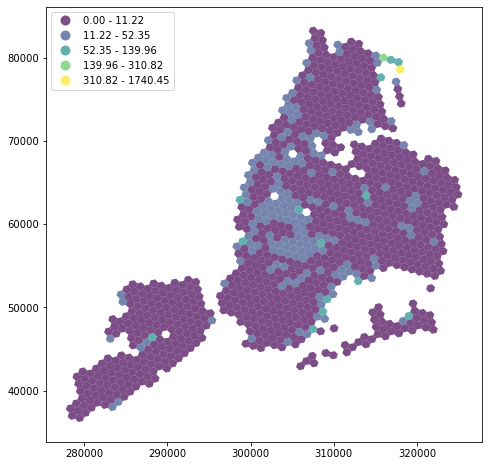

In [47]:
# inflow per hexbin on march 1st (friday) during the day, adjusted for population
hexes['population_adjusted_inflow'] = hexes['inflow_counts_daysample'] / hexes['day_pop']
filtered_hexes = hexes[hexes['day_pop'] != 0]

f, ax = plt.subplots(1, figsize=(8, 8))
ax = filtered_hexes.plot(column='population_adjusted_inflow',
                         ax=ax,
                         legend=True,
                         legend_kwds={'loc': 'upper left'},
                         alpha=0.7,
                         scheme='FisherJenks',
                         k=5)
plt.show();

In [16]:
# How to standardize above?
# Taxi rides per population (day/night)?
# Intensive variable?

for each taxizone(day/night):
- spatial join to capture overlapping hexes
- sum total population of overlapping hexes
- 